# Intro.

- CC에 대해서 전체 결과를 통합해서 표현

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from glob import glob 
import configparser
import scipy.io as sio
from pandas import Series, DataFrame
import pandas as pd

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# survey_final
cc_real_corr_list = [[297, 2450], [350, 1398], [351, 1399], [352, 1400], [353, 1401], [355, 1403], [385, 1441], [390, 1448], [392, 1450], [393, 1451], [394, 1452], [395, 1453], [400, 1460], [401, 1461], [525, 1601], [527, 1603], [528, 1604], [530, 1608], [531, 1609], [532, 1610], [535, 1611], [535, 1613], [536, 1614], [537, 1615], [538, 1616], [539, 1617], [540, 1618], [541, 1619], [543, 1619], [544, 1620], [545, 1621], [547, 1623], [701, 1769], [703, 1771], [705, 1773], [707, 1775], [749, 1819], [853, 1929], [939, 2017], [940, 2018], [941, 2019], [942, 2020], [943, 2021], [944, 2022], [945, 2023], [946, 2024], [947, 2025], [948, 2026], [949, 2027], [950, 2028], [951, 2029], [952, 2030], [953, 2031], [954, 2032], [955, 2033], [956, 2034], [957, 2035], [958, 2036], [959, 2037], [960, 2038], [961, 2039], [962, 2040], [963, 2041], [964, 2042], [965, 2043], [985, 2063], [986, 2064], [987, 2065], [988, 2066], [989, 2067], [990, 2068], [991, 2069], [992, 2070], [993, 2071], [994, 2072], [995, 2073], [996, 2074], [1002, 2080], [1003, 2081], [1004, 2082], [1005, 2083], [1073, 2149], [1148, 2222], [1205, 2283], [1206, 2284], [1207, 2285], [1216, 2294], [1225, 2303], [1226, 2304], [1227, 2305], [1228, 2306], [1228, 2308], [1229, 2307], [1230, 2310], [1231, 2311], [1232, 2312], [1241, 2319], [1242, 2320], [1243, 2321], [1244, 2322], [1245, 2323], [1247, 2325], [1248, 2326], [1275, 2355], [1284, 2362], [1285, 2363], [1286, 2364], [1287, 2365], [1288, 2366], [1289, 2367], [1290, 2368], [1291, 2369], [1296, 2374], [1300, 2378], [1301, 2379], [1302, 2378], [1302, 2380], [1303, 2379], [1303, 2381], [1305, 2381], [1306, 2382], [1348, 2428], [295, 2452], [299, 2448], [354, 1402], [384, 1440], [389, 1447], [391, 1449], [541, 1617], [702, 1770], [704, 1772], [706, 1774], [709, 1777], [748, 1818], [750, 1819], [750, 1820], [1233, 2313], [1273, 2353], [1274, 2354], [1345, 2425], [1347, 2427]]

In [3]:
len(np.unique(cc_real_corr_list))

270

# Manual GT image set organization

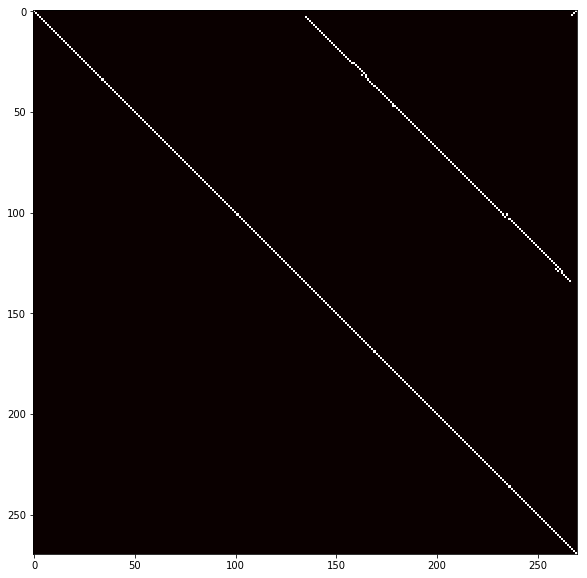

In [4]:
image_idx_order = np.unique(cc_real_corr_list)

GT_corr_mat = np.zeros((len(image_idx_order),len(image_idx_order)))

for a, i in enumerate(image_idx_order):
    for b, j in enumerate(image_idx_order):
        if i==j:
            GT_corr_mat[a,b] = 1
        if [i,j] in cc_real_corr_list:
            GT_corr_mat[a,b] = 1

plt.figure(figsize=(10,10))
plt.imshow(GT_corr_mat, cmap = 'hot')
plt.show()

In [5]:
def PrecisionRecallCurve(GT_corr_mat, esti_corr_mat):

    precision, recall, _ = precision_recall_curve(GT_corr_mat.flatten(), esti_corr_mat.flatten())
    average_precision = average_precision_score(GT_corr_mat.flatten(), esti_corr_mat.flatten())


    # Plot Precision-Recall curve
#     plt.clf()
#     plt.plot(recall, precision, lw=2, color='navy', label='Precision-Recall curve')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.ylim([0.0, 1.05])
#     plt.xlim([0.0, 1.0])
#     plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
#     plt.legend(loc="lower left")
#     plt.show()
    
    return precision, recall, average_precision
    
def theLatestResult(path_pattern):
    result_dirs = sorted(glob(path_pattern))
    the_latest_result_path = result_dirs[-1]
    print(the_latest_result_path)
    corr_mat_path = the_latest_result_path + '/corr_matrix.txt'
    param_cfg_path = the_latest_result_path + '/parameters.cfg'
    
    config = configparser.ConfigParser()
    config.read(param_cfg_path)
    print(dict(config.items('General')))
    

    return corr_mat_path, param_cfg_path

def theSpecificResult(path):
    corr_mat_path = path + '/corr_matrix.txt'
    param_cfg_path = path + '/output_config.ini'
    
    config = configparser.ConfigParser()
    config.read(param_cfg_path)
#     print(dict(config.items('Experiment_parameters')))
    
    return corr_mat_path, param_cfg_path, dict(config.items('Experiment_parameters'))


def parameter_inspection(params, exp_dict):
    if (params['cluster_center'] != str(exp_dict['cluster_center'])):
        print('different cluster center')
    if (params['depth_level'] != str(exp_dict['depth_level'])):
        print('different depth level')

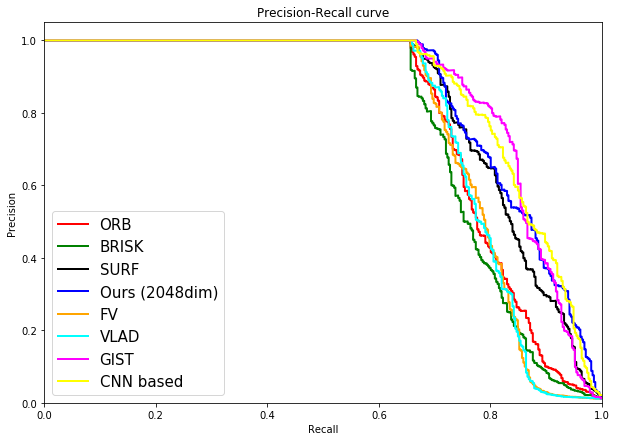

In [6]:
ap_results = {}

## local feature descriptor based method
exp_dict = {
    'cluster_center' : 10,
    'depth_level' : 5
}

testcases = [
'/home/dongwonshin/Desktop/LoopClosureDetectionTestBed/result_folder/2017-10-02-20-42-19',
'/home/dongwonshin/Desktop/LoopClosureDetectionTestBed/result_folder/2017-10-02-20-39-47',
'/home/dongwonshin/Desktop/LoopClosureDetectionTestBed/result_folder/2017-10-02-20-30-27',
'/home/dongwonshin/Desktop/LoopClosureDetectionTestBed/result_folder/2017-10-02-17-55-21',
]
curve_results = []
for testcase in testcases:
    corr_mat, param_cfg, params = theSpecificResult(testcase)
    parameter_inspection(params, exp_dict)
        
    esti_corr_mat = np.loadtxt(corr_mat)
    curve_results.append([PrecisionRecallCurve(GT_corr_mat, esti_corr_mat), params])
    
# Plot Precision-Recall curve
plt.figure(figsize=(10,7))
plt.clf()
for curve, color in zip(curve_results, ['red','green','black','blue']):
    if (curve[1]['exp_method'] == 'proposed method'):
        plt.plot(curve[0][1], curve[0][0], lw=2, color=color, label='Ours (2048dim)') 
        ap_results['Ours (2048dim)'] = curve[0][2]
    else:
        plt.plot(curve[0][1], curve[0][0], lw=2, color=color, label=curve[1]['exp_method'].upper())
        ap_results[curve[1]['exp_method']] = curve[0][2]


## whole image descriptor based method
# CC, vlfeat, FV 
mat_contents = sio.loadmat('vlfeat_results/20171006/FV_CC_corr_matrix.mat')
corr_matrix = mat_contents['corr_matrix']
FV_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)
plt.plot(FV_result[1], FV_result[0], lw=2, color='orange', label='FV')
ap_results['FV'] = FV_result[2]
    
# CC, vlfeat, VLAD 
mat_contents = sio.loadmat('vlfeat_results/20171006/vlad_CC_corr_matrix.mat')
corr_matrix = mat_contents['corr_matrix']
vlad_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)
plt.plot(vlad_result[1], vlad_result[0], lw=2, color='cyan', label='VLAD')
ap_results['VLAD'] = vlad_result[2]

mat_contents = sio.loadmat('gistdesc_results/gistdesc_cc.mat')
corr_matrix = mat_contents['est_corr_mat']
gist_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)
plt.plot(gist_result[1], gist_result[0], lw=2, color='magenta', label='GIST')
ap_results['GIST'] = gist_result[2]

corr_matrix = np.loadtxt('cnnbased_results/cnnbased_CC.txt')
cnnbased_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)
plt.plot(cnnbased_result[1], cnnbased_result[0], lw=2, color='yellow', label='CNN based')
ap_results['CNN_based'] = cnnbased_result[2]

# # CC, vlfeat, VLAD 
# mat_contents = sio.loadmat('vlfeat_results/20171006/bovw_CC_corr_matrix.mat')
# corr_matrix = mat_contents['corr_matrix']
# vlad_result = PrecisionRecallCurve(GT_corr_mat, corr_matrix)
# plt.plot(vlad_result[1], vlad_result[0], lw=2, color='magenta', label='SIFT (vlfeat)')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left", prop={'size':15})
plt.show()

In [28]:
DataFrame([ap_results], columns=ap_results.keys())

,CNN_based,SURF,brisk,orb,VLAD,FV,GIST,Ours (1024dim)
0,0.864925,0.835172,0.772833,0.791548,0.784781,0.783682,0.863494,0.852243
